# NGFF transforms in xarray wth CoordinateTransformIndex

Overview: https://xarray-indexes.readthedocs.io/blocks/transform.html
Further links:
- https://docs.xarray.dev/en/latest/generated/xarray.indexes.CoordinateTransformIndex.html#xarray.indexes.CoordinateTransformIndex
- https://docs.xarray.dev/en/latest/generated/xarray.indexes.CoordinateTransform.html#xarray.indexes.CoordinateTransform

More xarray functionality nicely shown here: https://xarray-indexes.readthedocs.io/index.html

In [1]:
from collections.abc import Hashable
from typing import Any

import networkx as nx
import numpy as np
import xarray as xr

from ome_zarr_models._v06.coordinate_transforms import CoordinateSystem, CoordinateSystemIdentifier

# from ngff_transformations.graph import get_relative_path, create_sequence_transformation_from_path
from ngff_transformations.graph import create_sequence_transformation_from_graph_walk, find_walks_in_graph, get_node

In [2]:
class NGFFXarrayCoordinateSystem(xr.indexes.CoordinateTransform):
    """
    Adapter class that represents NGFF coordinate systems in xarray.
    """

    def __init__(
            self,
            source_name: str,
            target_name: str,
            shape: tuple[int, ...],
            graph: nx.DiGraph,
            source_path: str = None,
            target_path: str = None,
        ):

        self.target_coord_system = graph.nodes[get_node(target_path, target_name)]['coordinate_system']

        try:

            walk = find_walks_in_graph(
                graph,
                src_name=source_name,
                src_path=source_path,
                tgt_name=target_name,
                tgt_path=target_path,
            )
# def find_walks_in_graph(graph, src_path, src_name, tgt_path, tgt_name) -> list[str | CoordinateSystemIdentifier]:

            transform = create_sequence_transformation_from_graph_walk(
                graph=graph,
                walk=walk,
            )

            self.transform = transform
        except:
            raise ValueError(f"No transformation path found from {source_name} to {target_name}.")

        self.graph = graph

        dim_names = [ax.name for ax in self.target_coord_system.axes]
        # dim_shapes = [shape[i] for i in range(len(dim_names))]
        dim_shapes = {dim: shape[i] for i, dim in enumerate(dim_names)}

        super().__init__(
            dim_names, dim_shapes, dtype=np.dtype(float)
        )


    def forward(
        self, dim_positions: dict[str, Any]
    ) -> dict[Hashable, Any]:
        """Perform array -> coordinate system transformation."""

        pixel = [dim_positions[dim] for dim in self.dims]
        world = self.transform.transform_point(pixel)

        return {name: w for name, w in zip(self.coord_names, world)}

    def reverse(
        self, coord_labels: dict[Hashable, Any]
    ) -> dict[str, Any]:
        """Perform coordinate system -> array coordinate reverse transformation."""

        if self.inverse_transform is None:
            raise ValueError("Transformation is not invertible (or inverse is not yet implemented).")

        world = [coord_labels[name] for name in self.coord_names]
        pixel = self.inverse_transform.transform_point(world)

        return {name: p for name, p in zip(self.dims, pixel)}



## Loading example data

In [3]:
from ngff_transformations.graph import transform_graph_to_networkx
from ome_zarr_models._v06.image import Image
import zarr
import dask.array as da

zarr_path = "/Users/albertm/software/ngff-transformations/data/full-ome-zarr-examples/example1.zarr"
# zarr_path = "../data/ngff-rfc5-coordinate-transformation-examples/3d/simple/rotation.zarr"

source_name = 'level2'
target_name = 'world'

group = Image.from_zarr(zarr.open_group(zarr_path, mode="r"))

# Create and validate graph
graph = group.transform_graph()
nx_graph = transform_graph_to_networkx(graph)
zarr_group = zarr.open_group(zarr_path, mode="r")
array_data = da.from_zarr(zarr_group[source_name])
array_shape = array_data.shape

nx_graph.edges

OutEdgeView([('physical', 'world'), ('physical', 'level0'), ('physical', 'level1'), ('physical', 'level2'), ('level0', 'physical'), ('level1', 'physical'), ('level2', 'physical')])

## Instanciating a xarray.DataArray with CoordinateTransformIndex

In [23]:
ngff_xarray_coord_system_transform = NGFFXarrayCoordinateSystem(
    source_path=None,
    source_name="level0",
    target_path=None,
    target_name=target_name,
    shape=array_shape,
    graph=nx_graph,
)

ngff_xarray_coord_system_transform

index = xr.indexes.CoordinateTransformIndex(ngff_xarray_coord_system_transform)
index.to_pandas_index = lambda: (_ for _ in ()).throw(TypeError("Cannot convert NGFF coordinate system transform to pandas Index."))
coords = xr.Coordinates.from_xindex(index)

xim = xr.DataArray(
    array_data,
    coords=coords,
)

# access the class above after instantiation:
xim._indexes['x'].transform.target_coord_system

xim

<xarray.DataArray 'from-zarr-d38dd0331962369cc3be96b641479766' (z: 60, c: 2,
                                                                y: 64, x: 64)> Size: 4MB
dask.array<from-zarr, shape=(60, 2, 64, 64), dtype=float64, chunksize=(60, 2, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * z        (z, c, y, x) float64 4MB 0.0 0.0 0.0 0.0 ... 29.5 29.5 29.5 29.5
  * c        (z, c, y, x) float64 4MB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
  * y        (z, c, y, x) float64 4MB 0.0 -0.1414 -0.2828 ... 0.1414 1.776e-15
  * x        (z, c, y, x) float64 4MB 0.0 0.1414 0.2828 ... 17.54 17.68 17.82
Indexes:
  ┌ z        CoordinateTransformIndex
  │ c
  │ y
  └ x

## coordinates plot

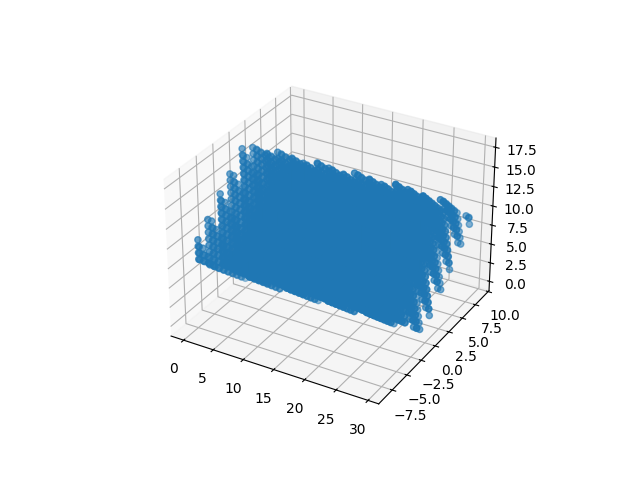

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib ipympl

# extract coordinates

pts = np.array([
    ngff_xarray_coord_system_transform.generate_coords()[dim] for dim in xim.dims
]).reshape(4, -1)
pts = pts[[i for i, ax in enumerate(xim._indexes['x'].transform.target_coord_system.axes) if ax.type == 'space']]
pts = pts[:, ::100]

# 3d matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[0], pts[1], pts[2])
plt.show()

## dask array

In [6]:
# dask array

array_data

dask.array<from-zarr, shape=(60, 2, 64, 64), dtype=float64, chunksize=(60, 2, 64, 64), chunktype=numpy.ndarray>

## dask + xarray

In [7]:
xim = xr.DataArray(
    array_data,
    dims=['z', 'c', 'y', 'x'],
    coords={
        dim: np.arange(size) * 0.1 # just an example scaling
        for dim, size in zip(['z', 'c', 'y', 'x'], array_shape)}
)
xim

<xarray.DataArray 'from-zarr-d38dd0331962369cc3be96b641479766' (z: 60, c: 2,
                                                                y: 64, x: 64)> Size: 4MB
dask.array<from-zarr, shape=(60, 2, 64, 64), dtype=float64, chunksize=(60, 2, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * z        (z) float64 480B 0.0 0.1 0.2 0.3 0.4 0.5 ... 5.5 5.6 5.7 5.8 5.9
  * c        (c) float64 16B 0.0 0.1
  * y        (y) float64 512B 0.0 0.1 0.2 0.3 0.4 0.5 ... 5.9 6.0 6.1 6.2 6.3
  * x        (x) float64 512B 0.0 0.1 0.2 0.3 0.4 0.5 ... 5.9 6.0 6.1 6.2 6.3

## dask + xarray + NGFFXarrayCoordinateSystem

In [25]:
ngff_xarray_coord_system_transform = NGFFXarrayCoordinateSystem(
    source_name=source_name,
    target_name=target_name,
    shape=array_shape,
    graph=nx_graph,
)

index = xr.indexes.CoordinateTransformIndex(ngff_xarray_coord_system_transform)
coords = xr.Coordinates.from_xindex(index)

xim_ngff = xr.DataArray(
    array_data,
    coords=coords,
)

xim_ngff

<xarray.DataArray 'from-zarr-d38dd0331962369cc3be96b641479766' (z: 60, c: 2,
                                                                y: 64, x: 64)> Size: 4MB
dask.array<from-zarr, shape=(60, 2, 64, 64), dtype=float64, chunksize=(60, 2, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * z        (z, c, y, x) float64 4MB 0.0 0.0 0.0 0.0 ... 118.0 118.0 118.0
  * c        (z, c, y, x) float64 4MB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
  * y        (z, c, y, x) float64 4MB 2.776e-17 -0.5657 ... 0.5657 7.105e-15
  * x        (z, c, y, x) float64 4MB 0.4243 0.9899 1.556 ... 70.57 71.13 71.7
Indexes:
  ┌ z        CoordinateTransformIndex
  │ c
  │ y
  └ x

## Transformation graph can be extracted from xarray DataArray

... without using attributes

In [27]:
xim_ngff._indexes['x'].transform.graph.nodes
xim_ngff._indexes['x'].transform.target_coord_system

CoordinateSystem(name='world', axes=(Axis(name='z', type='space', discrete=None, unit='um', longName=None), Axis(name='c', type='channel', discrete=True, unit=None, longName=None), Axis(name='y', type='space', discrete=None, unit='um', longName=None), Axis(name='x', type='space', discrete=None, unit='um', longName=None)))

## Downstream processing

### "classical" xarray.DataArray

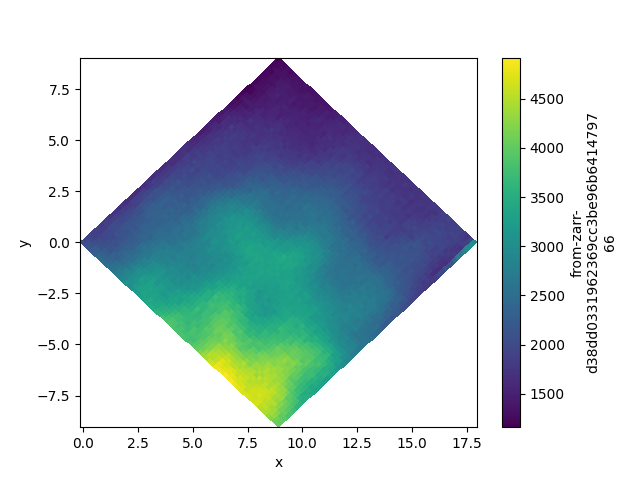

In [29]:
xim_plot = xim.isel(c=0, z=0)

plt.figure()
xim_plot.plot.pcolormesh(
    x="x",
    y="y",
)

### "functional" coordinate arrays + xarray

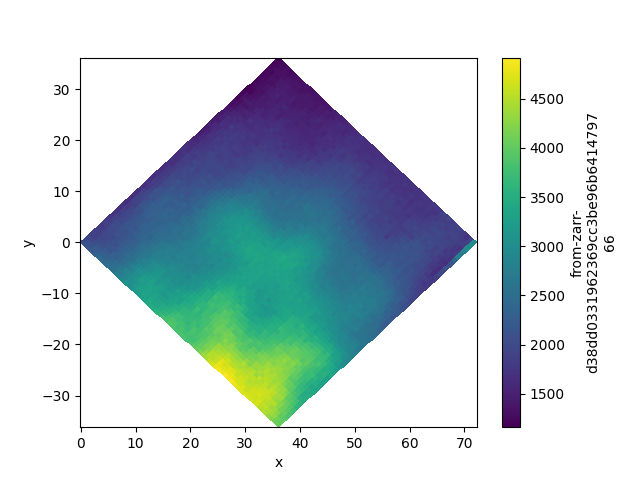

In [13]:
xim_plot = xim_ngff.isel(c=0, z=0)

plt.figure()
xim_plot.plot.pcolormesh(
    x="x",
    y="y",
)

## xarray sel with CoordinateTransformIndex

... unfortunately is not supported (yet?)

In [18]:
xim_ngff

<xarray.DataArray 'from-zarr-d38dd0331962369cc3be96b641479766' (z: 60, c: 2,
                                                                y: 64, x: 64)> Size: 4MB
dask.array<from-zarr, shape=(60, 2, 64, 64), dtype=float64, chunksize=(60, 2, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * z        (z, c, y, x) float64 4MB 0.0 0.0 0.0 0.0 ... 118.0 118.0 118.0
  * c        (z, c, y, x) float64 4MB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
  * y        (z, c, y, x) float64 4MB 2.776e-17 -0.5657 ... 0.5657 7.105e-15
  * x        (z, c, y, x) float64 4MB 0.4243 0.9899 1.556 ... 70.57 71.13 71.7
Indexes:
  ┌ z        CoordinateTransformIndex
  │ c
  │ y
  └ x

In [22]:
xim_ngff.sel(
    x=slice(30, 50),
    y=slice(5, 7),
    z=slice(5, 10),
    c=slice(0, 1),
    method='nearest'
)

TypeError: CoordinateTransformIndex only supports advanced (point-wise) indexing with either xarray.DataArray or xarray.Variable objects.